In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

random_state = 6
np.random.seed(random_state)
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
get_ipython().run_line_magic('matplotlib', 'inline')

# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 18
    }

plt.rc('font', **font)
plt.rc('text', usetex=False)
# plt.style.use('classic')

color_map = 'viridis'

In [3]:
df_train = pd.read_csv('train.csv',na_values=-1)
df_test = pd.read_csv('test.csv',na_values=-1)

### Check if both test and train have the same shape

In [4]:
print('Training data shape: {}'.format(df_train.shape))
print('Training data shape: {}'.format(df_test.shape))

Training data shape: (595212, 59)
Training data shape: (892816, 58)


### Check if there are any missing values

In [5]:
print('Is null on train: {}'.format(df_train.isnull().any().any()))
print('Is null on test: {}'.format(df_test.isnull().any().any()))

Is null on train: True
Is null on test: True


### Descriptive statistics

In [6]:
df_train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,594996.000000,595212.000000,595129.000000,589403.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.359799,4.423318,0.416992,0.419038,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.663193,2.699902,0.493062,1.350023,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Heatmap 

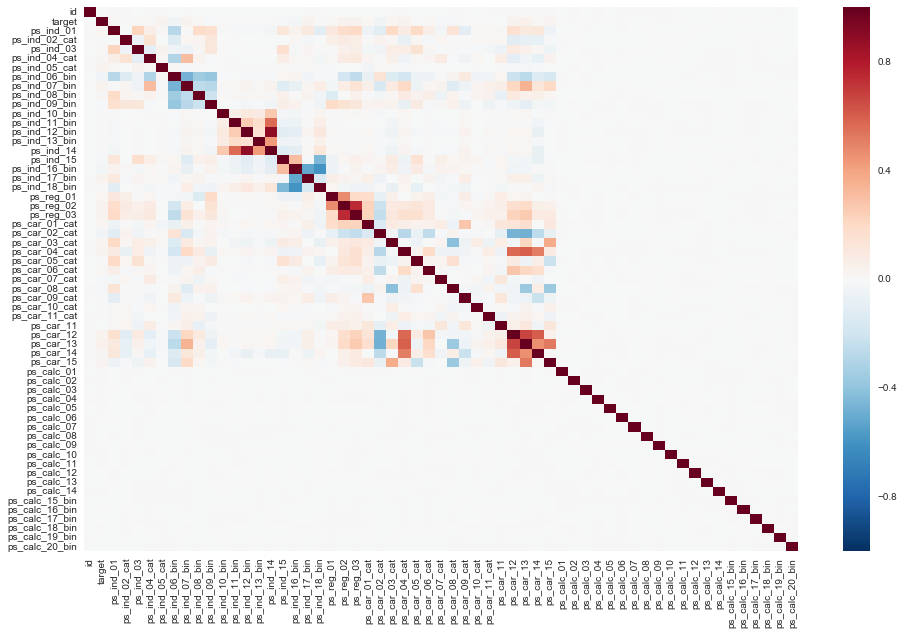

In [7]:
import seaborn as sns
cor = df_train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)

#### Since 'ps_calc' features do not show any have zero relationship with other features
#### We can delete them.

In [8]:
col_to_drop = df_train.columns[df_train.columns.str.startswith('ps_calc_')]
df_train = df_train.drop(col_to_drop, axis=1)  
df_test = df_test.drop(col_to_drop, axis=1)
print(df_train.shape)
print(df_test.shape)

(595212, 39)
(892816, 38)


## Work with missing values

In [9]:
df_train['target'] = df_train['target'].astype('category')

In [34]:
def get_missing_features(df):
    missings = pd.DataFrame([], columns=['feature', 'no_recoreds', 'percentage'])
    total_rows = df.shape[0]
    index = 0
    for feature in list(df):
        total_nulls = df[feature].isnull().sum()
        if total_nulls > 0:
            missings_perc = total_nulls / total_rows
            missings.loc[index] = [feature, total_nulls, missings_perc]
            index += 1
    missings = missings.sort_values('no_recoreds', ascending=False)
    return missings

In [36]:
df_missings = get_missing_features(df_train)
print(df_missings)

          feature no_recoreds  percentage
6   ps_car_03_cat      411231    0.690898
7   ps_car_05_cat      266551    0.447825
3       ps_reg_03      107772    0.181065
12      ps_car_14       42620    0.071605
8   ps_car_07_cat       11489    0.019302
2   ps_ind_05_cat        5809    0.009760
9   ps_car_09_cat         569    0.000956
0   ps_ind_02_cat         216    0.000363
4   ps_car_01_cat         107    0.000180
1   ps_ind_04_cat          83    0.000139
5   ps_car_02_cat           5    0.000008
10      ps_car_11           5    0.000008
11      ps_car_12           1    0.000002


### Bar plot of missing features

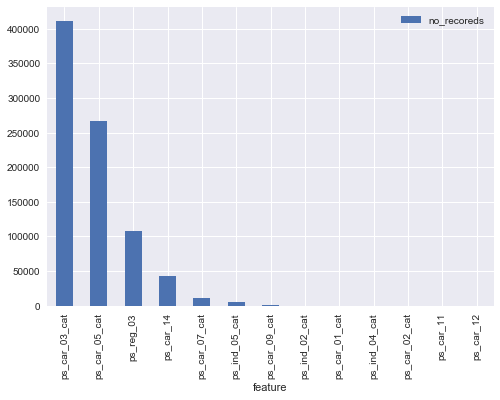

In [37]:
df_missings.plot(x='feature', y='no_recoreds', kind='bar', )

### Treat missing values by mean of the column

In [41]:
for i, feature in enumerate(list(df_train.drop(['id', 'target'], axis=1))):
    if df_train[feature].isnull().sum() > 0:
        df_train[feature].fillna(df_train[feature].mode()[0],inplace=True)

for i, feature in enumerate(list(df_test.drop(['id'], axis=1))):
    if df_test[feature].isnull().sum() > 0:
        df_test[feature].fillna(df_test[feature].mode()[0],inplace=True)

### Check if there are any missing values

In [42]:
get_missing_features(df_train)
get_missing_features(df_test)

,feature,no_recoreds,percentage


## Check category features of the dataset

In [40]:
cat_cols = [col for col in df_train.columns if '_cat' in col]
dummed_cols = []

for cat_col in cat_cols:
    unique_values = len(np.unique(df_train[cat_col]))
    if unique_values < 50:
        dummed_cols.append(cat_col)
    print('{} has {} unique values'.format(cat_col, unique_values))

ps_ind_02_cat has 4 unique values
ps_ind_04_cat has 2 unique values
ps_ind_05_cat has 7 unique values
ps_car_01_cat has 12 unique values
ps_car_02_cat has 2 unique values
ps_car_03_cat has 2 unique values
ps_car_04_cat has 10 unique values
ps_car_05_cat has 2 unique values
ps_car_06_cat has 18 unique values
ps_car_07_cat has 2 unique values
ps_car_08_cat has 2 unique values
ps_car_09_cat has 5 unique values
ps_car_10_cat has 3 unique values
ps_car_11_cat has 104 unique values


### Convert categorical variable into dummy variables

In [23]:
for cat_feature in cat_cols:
    df_train[cat_feature] = df_train[cat_feature].astype('uint8')
    df_test[cat_feature] = df_test[cat_feature].astype('uint8') 
    
df_train = pd.get_dummies(df_train, columns = dummed_cols)
df_test = pd.get_dummies(df_test, columns = dummed_cols)

print('Train: before {}, after {}'.format(df_train_shape_before, df_train.shape))
print('Test: before {}, after {}'.format(df_test_shape_before, df_test.shape))

Train: before (595212, 39), after (595212, 97)
Test: before (892816, 38), after (892816, 96)


## Handle outliers

### 1. Detect outliers

In [24]:
from collections import Counter

def detect_outlier(df):
    features = df.columns
    outliers  = []
    for i, feature in enumerate(features):
        if df[feature].dtype == 'float64':
            # Calculate Q1 (25th percentile of the data) for the given feature
            Q1 = np.percentile(df[feature], 25)
            # Calculate Q3 (75th percentile of the data) for the given feature
            Q3 = np.percentile(df[feature], 75)
            # Use the interquartile range to calculate an outlier step
            step = 1.5 * (Q3 - Q1)
            feature_outliers = df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))]
            outliers.extend(list(feature_outliers.index.values))
            print('Feature: {}, outliers: {}\n'.format(feature, len(feature_outliers.index)))
    
    multi_feature_outliers = (Counter(outliers) - Counter(set(outliers))).keys()
    return multi_feature_outliers

In [25]:
outliers  = detect_outlier(df_train.drop(['id', 'target'], axis = 1))

Feature: ps_reg_01, outliers: 0

Feature: ps_reg_02, outliers: 36793

Feature: ps_reg_03, outliers: 29363

Feature: ps_car_11, outliers: 25983

Feature: ps_car_12, outliers: 15355

Feature: ps_car_13, outliers: 26913

Feature: ps_car_14, outliers: 30420

Feature: ps_car_15, outliers: 27409



### 2. Remove outliers

In [27]:
good_data = df_train.drop(df_train.index[list(outliers)]).reset_index(drop = True)

print('Number of outliers occur more than one feature: {}'.format(len(outliers)))
print('Shape of old data: {}'.format(df_train.shape))
print('Shape of new data: {}'.format(good_data.shape))

Number of outliers occur more than one feature: 41446
Shape of old data: (595212, 97)
Shape of new data: (553766, 97)


In [43]:
print(df_train.shape, df_test.shape)

(595212, 39) (892816, 38)


## Split datasets into train and validation before fixing imbalance issue

In [47]:
# df_train = good_data
X_im = df_train.drop(['id','target'], axis = 1)
Y_im = df_train['target']

x_train_im, x_val_im, y_train_im, y_val_im = train_test_split(X_im, Y_im,
                                                  test_size = .3,
                                                  random_state=random_state)
print('Final shape of train data:{}'.format(X_im.shape))

Final shape of train data:(595212, 37)


## Handling imbalanced classes

### Plot class ratio

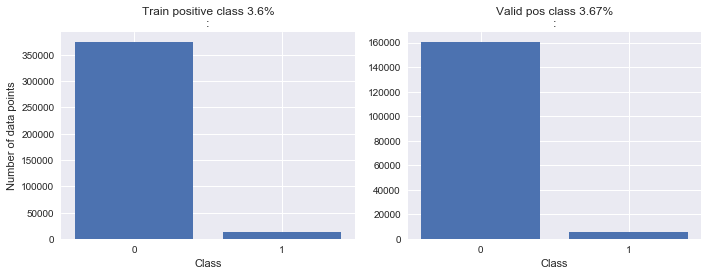

In [29]:
# Distribution of target variable
def plot_class_balace(train, val):
    train_aa = dict(Counter(train))
    val_aa = dict(Counter(val))
    
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.bar([0, 1], height= [train_aa[0],train_aa[1]])
    plt.xticks([0, 1]);
    plt.xlabel('Class')
    plt.ylabel('Number of data points')
    plt.title('Train positive class {}%\n:'.format(round(train_aa[1]*100/train_aa[0], 2)))
    
    plt.subplot(122)
    plt.bar([0, 1], height= [val_aa[0],val_aa[1]])
    plt.xticks([0, 1]);
    plt.xlabel('Class')
    plt.title('Valid pos class {}%\n:'.format(round(val_aa[1]*100/val_aa[0], 2)))
    plt.tight_layout()
    plt.show()

plot_class_balace(y_train_im, y_val_im)

### Upsampling positive class using the SMOTE algorithom

Original train shape Counter({0: 374161, 1: 13475})
Original validation shape Counter({0: 160251, 1: 5879})


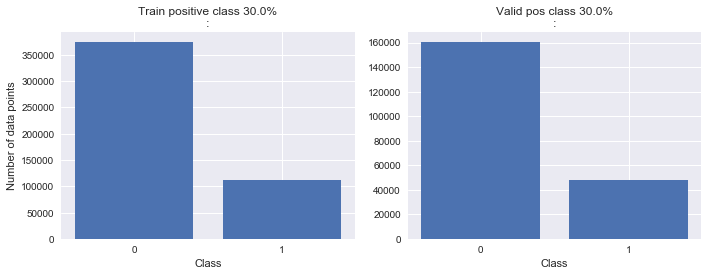

In [30]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

sm = SMOTE(ratio = 0.30, random_state = random_state, k_neighbors=5)

print('Original train shape {}'.format(Counter(y_train_im)))
print('Original validation shape {}'.format(Counter(y_val_im)))

X_train_ba, Y_train_ba = sm.fit_sample(x_train_im, y_train_im)
X_val_ba, Y_val_ba = sm.fit_sample(x_val_im, y_val_im)

plot_class_balace(Y_train_ba, Y_val_ba)

## Feature scaling

In [48]:
X_train, Y_train = shuffle(x_train_im, y_train_im, random_state = random_state)
X_val, Y_val = shuffle(x_val_im, y_val_im, random_state = random_state)

mms = StandardScaler()
X_train = mms.fit_transform(X_train)
X_val = mms.fit_transform(X_val)

### Gini coeficient 

In [49]:
# from https://www.kaggle.com/mashavasilenko/
# porto-seguro-xgb-modeling-and-parameters-tuning

def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

# def gini_xgb(preds, dtrain):
#     labels = dtrain.get_label()
#     gini_score = gini_normalized(labels, preds)
#     return [('gini', gini_score)]

## Model building using XGB

In [50]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [51]:
model = model = XGBClassifier(
              learning_rate = 0.02,
              n_estimators=100,
              max_depth  = 6, 
              subsample = 1.0, 
              colsample_bytree = 0.3,
              min_child_weight = 1,
              random_state = random_state,
              n_jobs = -1,
              silent = True)
eval_set = [(X_train, Y_train), (X_val, Y_val)]
model.fit(X_train, Y_train, eval_set= eval_set, 
          eval_metric= gini_xgb, early_stopping_rounds= 80, verbose=True)

[0]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.182845	validation_1-gini:0.185709
Multiple eval metrics have been passed: 'validation_1-gini' will be used for early stopping.

Will train until validation_1-gini hasn't improved in 80 rounds.
[1]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.222038	validation_1-gini:0.220611
[2]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.231984	validation_1-gini:0.22852
[3]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.241303	validation_1-gini:0.238063
[4]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.247891	validation_1-gini:0.247603
[5]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.252256	validation_1-gini:0.249354
[6]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.252372	validation_1-gini:0.247447
[7]	validation_0-error:0.036534	validation_1

[71]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.287154	validation_1-gini:0.266747
[72]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.287854	validation_1-gini:0.267116
[73]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.288524	validation_1-gini:0.267944
[74]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.289495	validation_1-gini:0.268289
[75]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.289387	validation_1-gini:0.268095
[76]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.289447	validation_1-gini:0.268085
[77]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.289634	validation_1-gini:0.268451
[78]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0.290372	validation_1-gini:0.268894
[79]	validation_0-error:0.036534	validation_1-error:0.036245	validation_0-gini:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=6, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1.0)

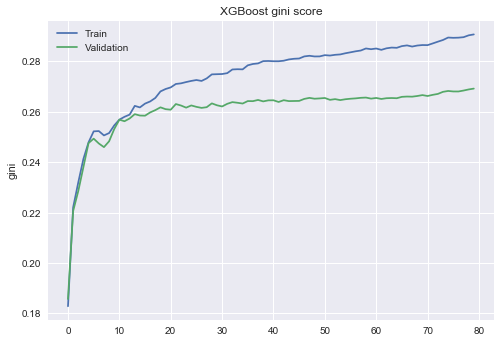

In [54]:
results = model.evals_result()
metric = 'gini'
epochs = len(results['validation_0'][metric])
x_axis = range(0, epochs)

plt.plot(x_axis, results['validation_0'][metric], label='Train')
plt.plot(x_axis, results['validation_1'][metric], label='Validation')
plt.legend()
plt.ylabel(metric)
plt.title('XGBoost ' +metric+  ' score')
plt.show()

### prepare test datasets

In [55]:
x_test = df_test.drop(['id'], axis = 1)
x_test_final = mms.fit_transform(x_test)

In [56]:
xgb_pred = model.predict_proba(x_test_final)
print(xgb_pred[0:10])
output = pd.DataFrame({'prediction': xgb_pred[:, 1]})
print(output.describe())
id_test = df_test['id'].values
output = pd.DataFrame({'id': id_test, 'target': xgb_pred[:, 1]})
output.to_csv('xgb_submit.csv', float_format='%.6f', index=False)

[[ 0.87969083  0.12030916]
 [ 0.87768006  0.12231991]
 [ 0.87351024  0.12648973]
 [ 0.88322574  0.11677425]
 [ 0.87271023  0.12728974]
 [ 0.87088424  0.12911578]
 [ 0.87477052  0.12522948]
 [ 0.87266314  0.12733683]
 [ 0.86234498  0.137655  ]
 [ 0.86159289  0.13840711]]
          prediction
count  892816.000000
mean        0.127566
std         0.008264
min         0.114144
25%         0.121766
50%         0.126044
75%         0.131350
max         0.271506


In [75]:
print(xgb_pred.shape)
print(model.classes_)
print(xgb_pred[:20, 1])

(892816, 2)
[0 1]
[ 0.99883717  0.99903023  0.99903166  0.99891567  0.99868542  0.99909699
  0.99866033  0.99876595  0.9989385   0.99854505  0.99906009  0.998869
  0.99841285  0.99830449  0.99906296  0.99906129  0.99900889  0.99916077
  0.99901509  0.99867946]


In [76]:
output.describe()

,id,target
count,8.928160e+05,892816.000000
mean,7.441535e+05,0.998776
std,4.296830e+05,0.000309
min,0.000000e+00,0.996685
25%,3.720218e+05,0.998614
50%,7.443070e+05,0.998863
75%,1.116308e+06,0.999001
max,1.488026e+06,0.999346
